In [1]:
# ============================================================================
# KLASIFIKASI DATA NAIVE BAYES
# ============================================================================

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00


In [4]:
# Text preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.2 MB/s eta 0:00:00


In [7]:
# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api

In [8]:
# Machine Learning
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [9]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
import pandas as pd

# Load data
df = pd.concat([
    pd.read_csv('komentar_negatif.csv', sep=';').assign(label='negatif'),
    pd.read_csv('komentar_netral.csv',  sep=';').assign(label='netral'),
    pd.read_csv('komentar_positif.csv', sep=';').assign(label='positif')
], axis=0).reset_index(drop=True)

# Cek data
print(df.head())
print(df.info())
print(df['label'].value_counts())

                                             comment    label
0  Over capacity ko masih impor, logikanya dimana...  negatif
1  Pak prabowo tolong ganti mentri esdm, bahlil h...  negatif
2  Bahlil...bahlil..sdh tdk percaya dgn manusia2 ...  negatif
3  Jebolan ITB lawan jebolan yg kampusnya nggak a...  negatif
4  Maaf dana nya abis di pake korupsi, ngak bangu...  negatif
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  300 non-null    object
 1   label    300 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB
None
label
negatif    100
netral     100
positif    100
Name: count, dtype: int64


In [12]:
# ============================================================================
# BAGIAN 2: TEXT PREPROCESSING (STEMMING & LEMMATIZATION)
# ============================================================================

print("\n[2] Text Preprocessing (Cleaning, Stemming, Stopword Removal)...")

# Initialize Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

factory_stopword = StopWordRemoverFactory()
stopword_remover = factory_stopword.create_stop_word_remover()

def clean_text(text):
    """Cleaning text"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

def preprocess_text(text):
    """Full preprocessing: cleaning, stopword removal, stemming"""
    # Clean
    text = clean_text(text)

    # Remove stopwords
    text = stopword_remover.remove(text)

    # Stemming
    text = stemmer.stem(text)

    return text

# Apply preprocessing
df['comment_clean'] = df['comment'].apply(clean_text)
df['comment_processed'] = df['comment'].apply(preprocess_text)

print("   ✓ Preprocessing selesai!")
print(f"\n   Contoh preprocessing:")
print(f"   Original : {df['comment'].iloc[0]}")
print(f"   Cleaned  : {df['comment_clean'].iloc[0]}")
print(f"   Processed: {df['comment_processed'].iloc[0]}")


[2] Text Preprocessing (Cleaning, Stemming, Stopword Removal)...
   ✓ Preprocessing selesai!

   Contoh preprocessing:
   Original : Over capacity ko masih impor, logikanya dimana? Salah satu mafianya nongol
   Cleaned  : over capacity ko masih impor logikanya dimana salah satu mafianya nongol
   Processed: over capacity ko impor logika salah satu mafia nongol


In [13]:
# ============================================================================
# BAGIAN 3: SPLIT DATA
# ============================================================================

print("\n[3] Splitting Data (80% Train, 20% Test)...")

X = df['comment_processed']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training data: {len(X_train)}")
print(f"   Testing data: {len(X_test)}")


[3] Splitting Data (80% Train, 20% Test)...
   Training data: 240
   Testing data: 60


In [14]:
# ============================================================================
# BAGIAN 4: FEATURE EXTRACTION & CLASSIFICATION
# ============================================================================

results = []

print("\n" + "="*80)
print("FEATURE EXTRACTION & CLASSIFICATION")
print("="*80)


FEATURE EXTRACTION & CLASSIFICATION


In [15]:
# ----------------------------------------------------------------------------
# 4.1 TF-IDF
# ----------------------------------------------------------------------------

print("\n[4.1] TF-IDF + Naive Bayes")
print("-" * 50)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
rec_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

print(f"   Accuracy : {acc_tfidf:.4f}")
print(f"   Precision: {prec_tfidf:.4f}")
print(f"   Recall   : {rec_tfidf:.4f}")
print(f"   F1-Score : {f1_tfidf:.4f}")

results.append({
    'Method': 'TF-IDF',
    'Accuracy': acc_tfidf,
    'Precision': prec_tfidf,
    'Recall': rec_tfidf,
    'F1-Score': f1_tfidf
})

print("\n   Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


[4.1] TF-IDF + Naive Bayes
--------------------------------------------------
   Accuracy : 0.6667
   Precision: 0.6678
   Recall   : 0.6667
   F1-Score : 0.6670

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.60      0.60      0.60        20
      netral       0.67      0.70      0.68        20
     positif       0.74      0.70      0.72        20

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60



In [16]:
# ----------------------------------------------------------------------------
# 4.2 BAG OF WORDS (BOW)
# ----------------------------------------------------------------------------

print("\n[4.2] Bag of Words (BOW) + Naive Bayes")
print("-" * 50)

bow_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

acc_bow = accuracy_score(y_test, y_pred_bow)
prec_bow = precision_score(y_test, y_pred_bow, average='weighted')
rec_bow = recall_score(y_test, y_pred_bow, average='weighted')
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"   Accuracy : {acc_bow:.4f}")
print(f"   Precision: {prec_bow:.4f}")
print(f"   Recall   : {rec_bow:.4f}")
print(f"   F1-Score : {f1_bow:.4f}")

results.append({
    'Method': 'Bag of Words',
    'Accuracy': acc_bow,
    'Precision': prec_bow,
    'Recall': rec_bow,
    'F1-Score': f1_bow
})

print("\n   Classification Report:")
print(classification_report(y_test, y_pred_bow))


[4.2] Bag of Words (BOW) + Naive Bayes
--------------------------------------------------
   Accuracy : 0.6833
   Precision: 0.6833
   Recall   : 0.6833
   F1-Score : 0.6833

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.60      0.60      0.60        20
      netral       0.70      0.70      0.70        20
     positif       0.75      0.75      0.75        20

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60



In [17]:
# ----------------------------------------------------------------------------
# 4.3 WORD2VEC
# ----------------------------------------------------------------------------

print("\n[4.3] Word2Vec + Naive Bayes")
print("-" * 50)

# Tokenize untuk Word2Vec
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Train Word2Vec model
print("   Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

def document_vector(doc, model):
    """Convert document to average word vector"""
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# Convert to vectors
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in X_train_tokens])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in X_test_tokens])

# Gaussian Naive Bayes (karena Word2Vec menghasilkan nilai kontinu)
model_w2v = GaussianNB()
model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = model_w2v.predict(X_test_w2v)

acc_w2v = accuracy_score(y_test, y_pred_w2v)
prec_w2v = precision_score(y_test, y_pred_w2v, average='weighted')
rec_w2v = recall_score(y_test, y_pred_w2v, average='weighted')
f1_w2v = f1_score(y_test, y_pred_w2v, average='weighted')

print(f"   Accuracy : {acc_w2v:.4f}")
print(f"   Precision: {prec_w2v:.4f}")
print(f"   Recall   : {rec_w2v:.4f}")
print(f"   F1-Score : {f1_w2v:.4f}")

results.append({
    'Method': 'Word2Vec',
    'Accuracy': acc_w2v,
    'Precision': prec_w2v,
    'Recall': rec_w2v,
    'F1-Score': f1_w2v
})

print("\n   Classification Report:")
print(classification_report(y_test, y_pred_w2v))


[4.3] Word2Vec + Naive Bayes
--------------------------------------------------
   Training Word2Vec model...
   Accuracy : 0.4500
   Precision: 0.4615
   Recall   : 0.4500
   F1-Score : 0.4488

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.50      0.35      0.41        20
      netral       0.38      0.50      0.43        20
     positif       0.50      0.50      0.50        20

    accuracy                           0.45        60
   macro avg       0.46      0.45      0.45        60
weighted avg       0.46      0.45      0.45        60



In [18]:
# ----------------------------------------------------------------------------
# 4.4 GLOVE (Pre-trained)
# ----------------------------------------------------------------------------

print("\n[4.4] GloVe (Pre-trained) + Naive Bayes")
print("-" * 50)
print("   Loading pre-trained GloVe model (glove-wiki-gigaword-100)...")
print("   (This may take a while on first run...)")

try:
    # Load pre-trained GloVe
    glove_model = api.load("glove-wiki-gigaword-100")

    def document_vector_glove(doc, model):
        """Convert document to average GloVe vector"""
        vectors = []
        for word in doc:
            try:
                vectors.append(model[word])
            except KeyError:
                continue
        if len(vectors) == 0:
            return np.zeros(100)
        return np.mean(vectors, axis=0)

    # Convert to vectors
    X_train_glove = np.array([document_vector_glove(doc, glove_model) for doc in X_train_tokens])
    X_test_glove = np.array([document_vector_glove(doc, glove_model) for doc in X_test_tokens])

    # Gaussian Naive Bayes
    model_glove = GaussianNB()
    model_glove.fit(X_train_glove, y_train)
    y_pred_glove = model_glove.predict(X_test_glove)

    acc_glove = accuracy_score(y_test, y_pred_glove)
    prec_glove = precision_score(y_test, y_pred_glove, average='weighted')
    rec_glove = recall_score(y_test, y_pred_glove, average='weighted')
    f1_glove = f1_score(y_test, y_pred_glove, average='weighted')

    print(f"   Accuracy : {acc_glove:.4f}")
    print(f"   Precision: {prec_glove:.4f}")
    print(f"   Recall   : {rec_glove:.4f}")
    print(f"   F1-Score : {f1_glove:.4f}")

    results.append({
        'Method': 'GloVe',
        'Accuracy': acc_glove,
        'Precision': prec_glove,
        'Recall': rec_glove,
        'F1-Score': f1_glove
    })

    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred_glove))

except Exception as e:
    print(f"   ⚠ Error loading GloVe: {e}")
    print("   Skipping GloVe evaluation...")


[4.4] GloVe (Pre-trained) + Naive Bayes
--------------------------------------------------
   Loading pre-trained GloVe model (glove-wiki-gigaword-100)...
   (This may take a while on first run...)
[==================================================] 100.0% 128.1/128.1MB downloaded
   Accuracy : 0.5000
   Precision: 0.5385
   Recall   : 0.5000
   F1-Score : 0.4988

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.53      0.45      0.49        20
      netral       0.42      0.65      0.51        20
     positif       0.67      0.40      0.50        20

    accuracy                           0.50        60
   macro avg       0.54      0.50      0.50        60
weighted avg       0.54      0.50      0.50        60



In [19]:
# ============================================================================
# BAGIAN 5: COMPARISON & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("COMPARISON OF ALL METHODS")
print("="*80)

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))

# Save results to CSV
df_results.to_csv('classification_results.csv', index=False)
print("\n✓ Results saved to: classification_results.csv")

# Find best method
best_method = df_results.loc[df_results['Accuracy'].idxmax()]
print(f"\n🏆 Best Method: {best_method['Method']}")
print(f"   Accuracy: {best_method['Accuracy']:.4f}")
print(f"   F1-Score: {best_method['F1-Score']:.4f}")


COMPARISON OF ALL METHODS

       Method  Accuracy  Precision   Recall  F1-Score
      TF-IDF  0.666667   0.667836 0.666667  0.666959
Bag of Words  0.683333   0.683333 0.683333  0.683333
    Word2Vec  0.450000   0.461538 0.450000  0.448849
       GloVe  0.500000   0.538478 0.500000  0.498763

✓ Results saved to: classification_results.csv

🏆 Best Method: Bag of Words
   Accuracy: 0.6833
   F1-Score: 0.6833


In [20]:
# ============================================================================
# BAGIAN 6: VISUALIZATION
# ============================================================================

print("\n[6] Creating Visualizations...")


[6] Creating Visualizations...


   ✓ Saved: comparison_metrics.png


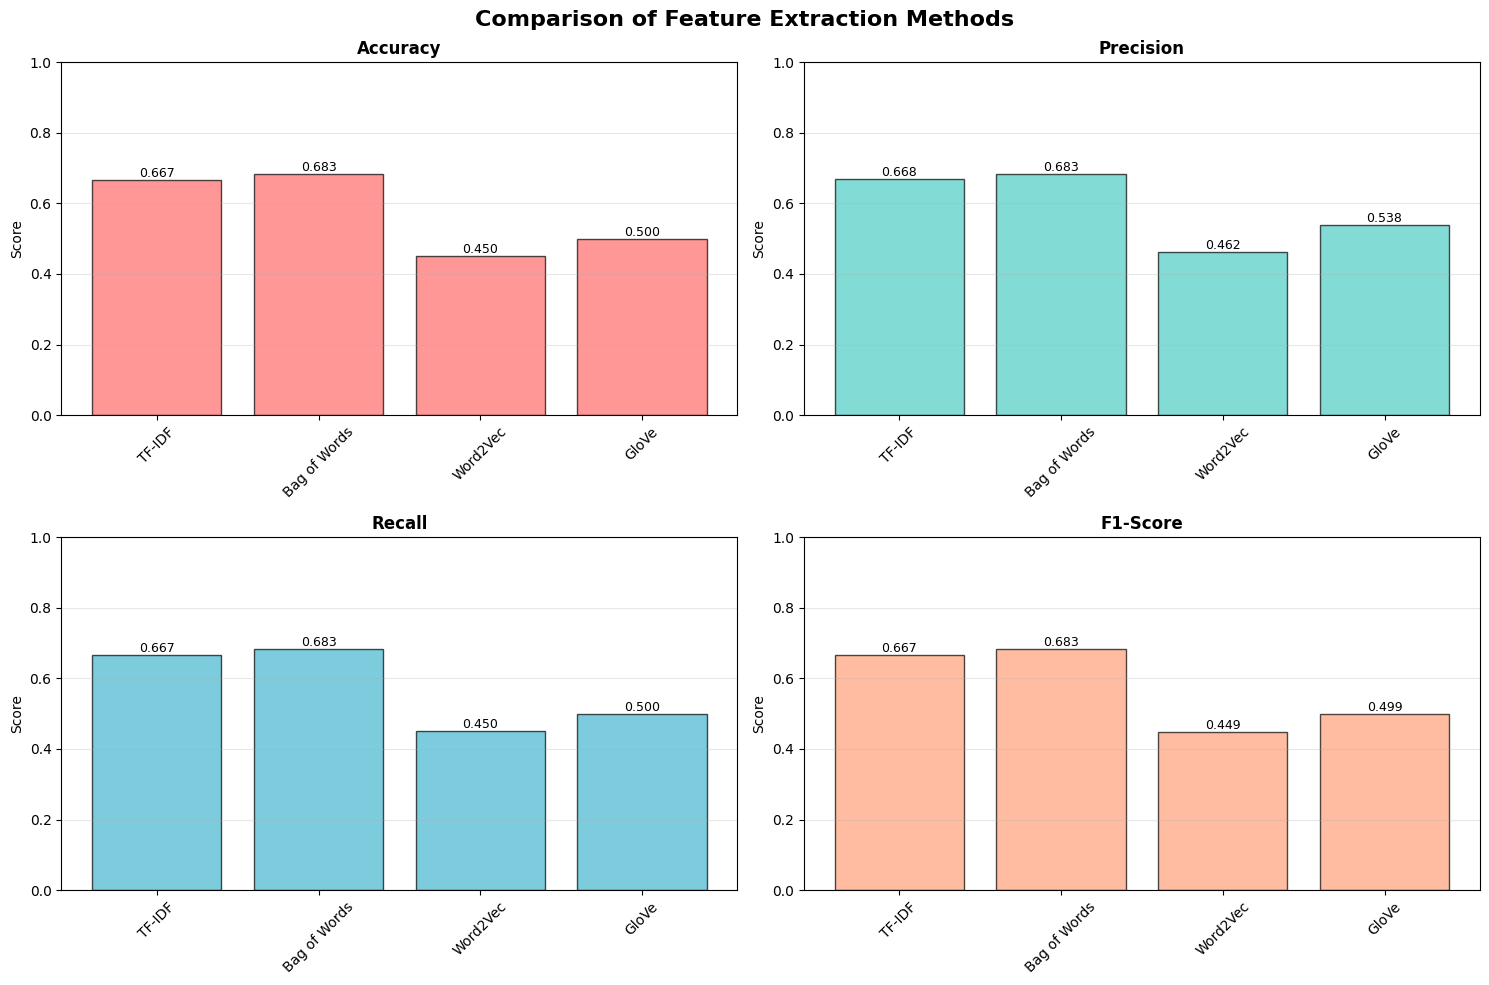

In [21]:
# 6.1 Comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Feature Extraction Methods', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
    bars = ax.bar(df_results['Method'], df_results[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_metrics.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: comparison_metrics.png")

   ✓ Saved: confusion_matrix_tfidf.png


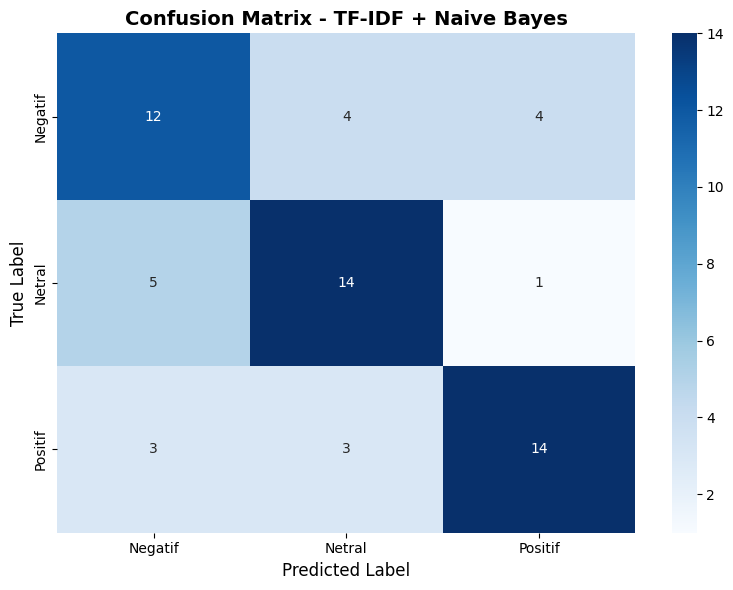

In [22]:
# 6.2 Confusion Matrix for best method (TF-IDF)
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'],
            ax=ax)
ax.set_title('Confusion Matrix - TF-IDF + Naive Bayes', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_tfidf.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: confusion_matrix_tfidf.png")

   ✓ Saved: radar_comparison.png


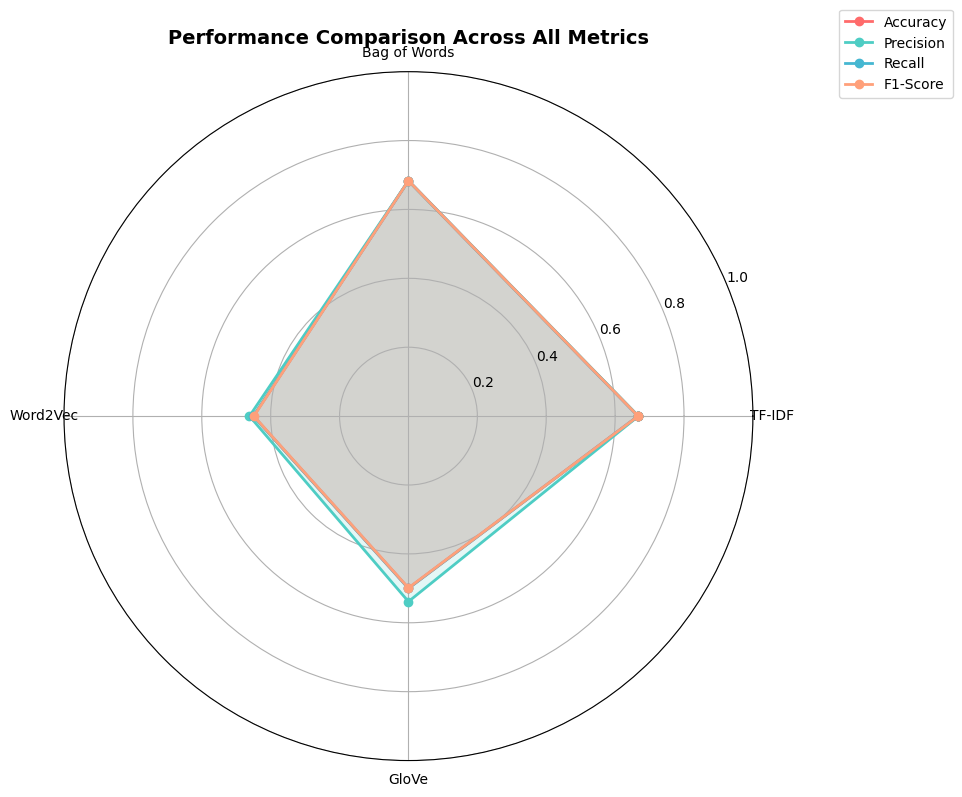

In [23]:
# 6.3 Overall comparison radar chart
from math import pi

categories = list(df_results['Method'])
N = len(categories)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for metric, color in zip(metrics_to_plot, colors_radar):
    values = df_results[metric].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=metric, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('Performance Comparison Across All Metrics',
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: radar_comparison.png")

In [24]:
# ============================================================================
# BAGIAN 7: SAVE PREDICTIONS
# ============================================================================

print("\n[7] Saving Predictions...")

# Create dataframe with predictions from all methods
df_predictions = pd.DataFrame({
    'comment_original': df.loc[X_test.index, 'comment'].values,
    'comment_processed': X_test.values,
    'true_label': y_test.values,
    'pred_tfidf': y_pred_tfidf,
    'pred_bow': y_pred_bow,
    'pred_word2vec': y_pred_w2v
})

# Add GloVe predictions if available
if 'y_pred_glove' in locals():
    df_predictions['pred_glove'] = y_pred_glove

df_predictions.to_csv('predictions_comparison.csv', index=False)
print("   ✓ Saved: predictions_comparison.csv")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("CLASSIFICATION COMPLETED!")
print("="*80)

print("\n📁 Output Files:")
print("   1. classification_results.csv - Performance metrics untuk semua metode")
print("   2. predictions_comparison.csv - Prediksi dari semua metode")
print("   3. comparison_metrics.png - Bar chart perbandingan metrik")
print("   4. confusion_matrix_tfidf.png - Confusion matrix TF-IDF")
print("   5. radar_comparison.png - Radar chart perbandingan performa")

print("\n📊 Summary:")
print(f"   ✓ Total data: {len(df)}")
print(f"   ✓ Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"   ✓ Feature extraction methods tested: {len(results)}")
print(f"   ✓ Best method: {best_method['Method']} (Accuracy: {best_method['Accuracy']:.4f})")

print("\n" + "="*80)


[7] Saving Predictions...
   ✓ Saved: predictions_comparison.csv

CLASSIFICATION COMPLETED!

📁 Output Files:
   1. classification_results.csv - Performance metrics untuk semua metode
   2. predictions_comparison.csv - Prediksi dari semua metode
   3. comparison_metrics.png - Bar chart perbandingan metrik
   4. confusion_matrix_tfidf.png - Confusion matrix TF-IDF
   5. radar_comparison.png - Radar chart perbandingan performa

📊 Summary:
   ✓ Total data: 300
   ✓ Training: 240 | Testing: 60
   ✓ Feature extraction methods tested: 4
   ✓ Best method: Bag of Words (Accuracy: 0.6833)

